# Starter code: from lecture 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
# build vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)
print(len(words))

32033


In [6]:
# build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words=words[:n1])
Xdev,Ydev = build_dataset(words=words[n1:n2])
Xte,Yte = build_dataset(words=words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# for x,y in zip(Xtr[:20], Ytr[:20]):
#     print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [9]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # making init - Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [10]:
torch.manual_seed(42)

In [11]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

12097


In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    loss = F.cross_entropy(x, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.2966
  10000 /  200000: 2.2322
  20000 /  200000: 2.4111
  30000 /  200000: 2.1004
  40000 /  200000: 2.3157
  50000 /  200000: 2.2104
  60000 /  200000: 1.9653
  70000 /  200000: 1.9767
  80000 /  200000: 2.6738
  90000 /  200000: 2.0837
 100000 /  200000: 2.2730
 110000 /  200000: 1.7491
 120000 /  200000: 2.2891
 130000 /  200000: 2.3443
 140000 /  200000: 2.1731
 150000 /  200000: 1.8246
 160000 /  200000: 1.7614
 170000 /  200000: 2.2419
 180000 /  200000: 2.0803
 190000 /  200000: 2.1326


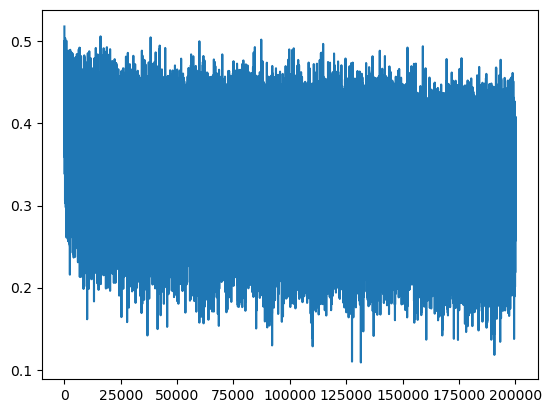

In [13]:
plt.plot(lossi)

In [14]:
# put the layers into eval mode (needed for BatchNorm especially)
for layer in layers:
    layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0],-1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [20]:
context = [0] * block_size
C[torch.tensor(context)].shape

torch.Size([3, 10])

In [22]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        # emb = C[torch.tensor(context)] # would have given shape (3,10)
        emb = C[torch.tensor([context])] # gives shape (1,3,10)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

tyre.
dia.
beir.
damelays.
kascacolton.
edinicioannie.
karleah.
arleniya.
doslaycensayah.
marelizion.
tamura.
fraelayanna.
kalin.
aldoncreigh.
katiya.
shalle.
ris.
taya.
abbikkingan.
azimith.


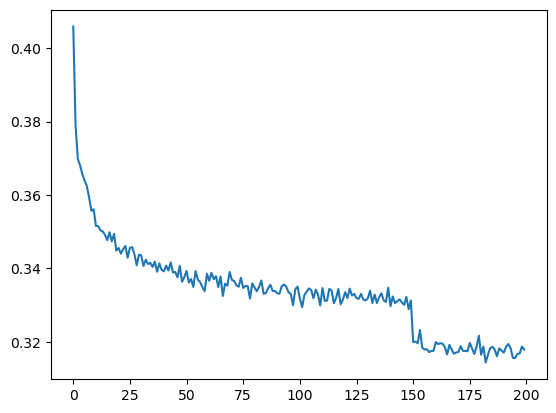

In [25]:
# fixing the learning rate plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# Simplify forward pass, new layers

In [26]:
# to further simplify forward pass

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [28]:
n_embd = 10
n_hidden = 200

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

12097


In [29]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    loss = F.cross_entropy(x, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0 /  200000: 3.2929


# PyTorch CONTAINERS

In [39]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [46]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = model.parameters() #[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

12097


In [47]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    # calculate loss
    loss = F.cross_entropy(logits, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.5468
  10000 /  200000: 2.4934
  20000 /  200000: 2.3816
  30000 /  200000: 2.2907
  40000 /  200000: 2.5158
  50000 /  200000: 1.6686
  60000 /  200000: 2.3934
  70000 /  200000: 1.9796
  80000 /  200000: 2.4848
  90000 /  200000: 2.0394
 100000 /  200000: 2.2528
 110000 /  200000: 2.2904
 120000 /  200000: 2.5159
 130000 /  200000: 2.0366
 140000 /  200000: 2.2680
 150000 /  200000: 2.4133
 160000 /  200000: 2.1382
 170000 /  200000: 2.0679
 180000 /  200000: 1.9742
 190000 /  200000: 2.2542


In [48]:
for layer in model.layers:
    layer.training = False

In [49]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06392502784729
val 2.1086156368255615


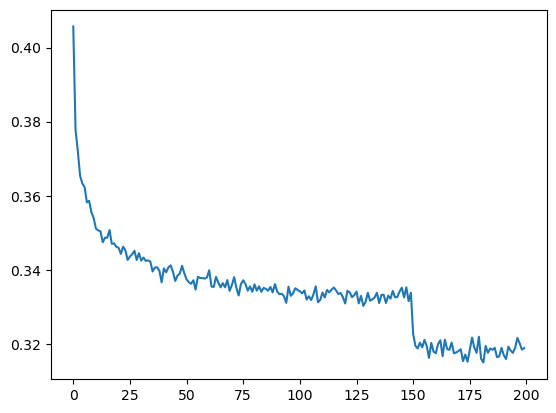

In [50]:
# fixing the learning rate plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [51]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        # emb = C[torch.tensor(context)] # would have given shape (3,10)
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

zude.
ren.
cli.
kynziel.
von.
icelen.
sivalynn.
shad.
ralden.
sotraquanderstyn.
cyemira.
irrenra.
mara.
korrin.
tasryn.
kaidy.
dalyn.
kamyal.
roi.
arta.
